<a href="https://colab.research.google.com/github/bundickm/Data-Masked-Case-Studies/blob/main/Optimizing_Conversion_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Conversion Rate
Understanding a sites conversion rate can make or break a company. By knowing what affects the conversion rate you can lower customer acquisition costs, acquire new customers, and increase revenue per visitor.

We've been asked in this case study to use the company's website data to predict the conversion rate. Additionally, we'll need to provide recommendations for the product and marketing teams.

## Data Description
- **country:** user country based on the IP address
- **age:** user age. Self-reported at sign-up step
- **new_user:** whether the user created the account during this session or had already an account and simply came back to the site
- **source:** marketing channel source
 - Ads: came to the site by clicking on an advertisement
 - Seo: came to the site by clicking on search results
 - Direct: came to the site by directly typing the URL on the browser
- **total_pages_visited:** number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement
- **converted:** this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase 
- **conversion rate:** # conversions / total sessions

# Imports and Settings

In [1]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 75kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=fe24130bb64da95d4e2312178d7b19f3d65e435f48a629e096195e9cf5f77839
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from pdpbox import pdp
from pdpbox import info_plots
import graphviz
from graphviz import Source

# Initial Exploration

In [3]:
df = pd.read_csv('PRIVATE CSV')

print(df.shape)
df.head()

(316200, 6)


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


Takeaways from `df.describe`
- Conversion Rate is 3.2%, about average for ecommerce <sub>[source](https://www.invespcro.com/blog/the-average-website-conversion-rate-by-industry/)</sub>
- Age skews young, but there is an extreme outlier of 123
- Most users are visiting 4-5 pages so an outlier of 29 is interesting
- The site sees quite a few new users, need a value_count to see distribution
- The site is majority new users (69%)

In [5]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Value Count Takeaways
- US based site (56%) with a large secondary market in China (24%)
- Biggest driver of traffic is SEO (49%)

In [6]:
for col in ['new_user', 'country', 'source']:
    print(df[col].value_counts(normalize=True))
    print()

1    0.685465
0    0.314535
Name: new_user, dtype: float64

US         0.563226
China      0.242258
UK         0.153226
Germany    0.041290
Name: country, dtype: float64

Seo       0.490323
Ads       0.280645
Direct    0.229032
Name: source, dtype: float64



Compared to the other features, `converted` and `total_pages_visited` have a high correlation. Nothing high enough on it's own to take action but worth noting, may be useful later.

In [7]:
df.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.012343,-0.045922,-0.088797
new_user,0.012343,1.000000,-0.082541,-0.152374
total_pages_visited,-0.045922,-0.082541,1.000000,0.528994
converted,-0.088797,-0.152374,0.528994,1.000000


Removing the two age outliers because they don't pass the sniff test and it will have minimal effect on the data. Curious how two extreme outliers snuck in, worth passing along to the data engineer who is in charge of logging so they can check for issues.

In [8]:
print(df[df['age'] > 100])
df = df[df['age'] < 100]

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


Checking the page visits, we see that the high page views are not uncommon. No need to do anything further.

In [9]:
df[df['total_pages_visited'] > 20]['total_pages_visited'].value_counts()

21    296
22    180
23    113
24     46
25     39
26     17
27      7
29      2
28      1
Name: total_pages_visited, dtype: int64

Plotting Takeaways
- While it looked like China was a strong secondary market, the conversion rate for it is near 0 for conversion rate. Something is driving Chinese users to the site but they aren't being monetized. Possible localization issues.
- Germany is a small percent of the site visits but has a conversion rate of almost double the average. Might be a growth opportunity to localize the site or dedicate ad revenue towards Germans.
- The site skews young and this is clearly by design with a higher conversion rate for the lower age ranges
- Returning users have a 7% conversion rate vs 1% for new users. Returning users are a proxy for product interest so it makes sense that they are higher.
- The more pages the user views, the more likely they are to purchase. Possible issue of data leakage here since the user has to view more pages to make a purchase.

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64


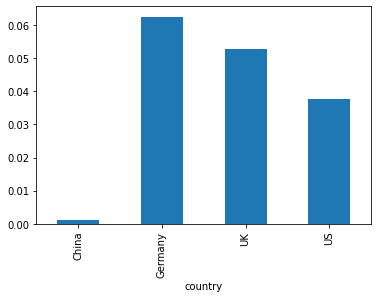

age
17    0.071607
18    0.066029
19    0.058616
20    0.057109
21    0.053985
22    0.053243
23    0.047990
24    0.045448
25    0.038782
26    0.039767
27    0.033513
28    0.032564
29    0.033621
30    0.028998
31    0.027461
32    0.024802
33    0.023989
34    0.021556
35    0.018394
36    0.019297
37    0.018953
38    0.014158
39    0.017313
40    0.014270
41    0.012342
42    0.013243
43    0.011623
44    0.009943
45    0.012383
46    0.011356
47    0.007987
48    0.009430
49    0.007366
50    0.005900
51    0.006404
52    0.005348
53    0.003190
54    0.001923
55    0.007614
56    0.000000
57    0.000000
58    0.012121
59    0.000000
60    0.021277
61    0.014085
62    0.000000
63    0.000000
64    0.000000
65    0.000000
66    0.000000
67    0.000000
68    0.000000
69    0.000000
70    0.000000
72    0.000000
73    0.000000
77    0.000000
79    0.000000
Name: converted, dtype: float64


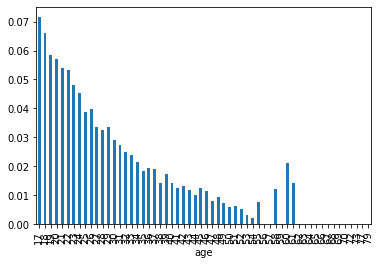

new_user
0    0.071983
1    0.014021
Name: converted, dtype: float64


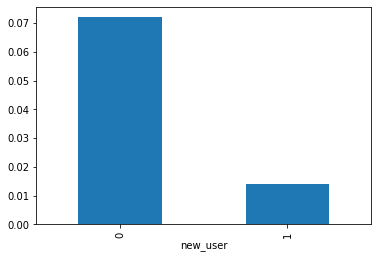

source
Ads       0.034472
Direct    0.028169
Seo       0.032888
Name: converted, dtype: float64


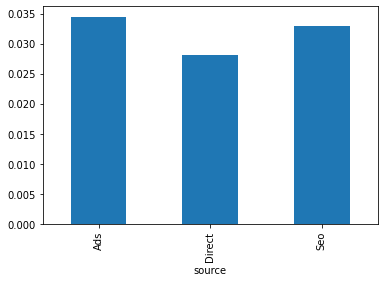

total_pages_visited
1     0.000000
2     0.000228
3     0.000251
4     0.000780
5     0.001570
6     0.003437
7     0.006769
8     0.015238
9     0.033067
10    0.061068
11    0.123471
12    0.244537
13    0.400825
14    0.587521
15    0.740181
16    0.871818
17    0.923077
18    0.961219
19    0.989381
20    0.997531
21    1.000000
22    1.000000
23    1.000000
24    1.000000
25    1.000000
26    1.000000
27    1.000000
28    1.000000
29    1.000000
Name: converted, dtype: float64


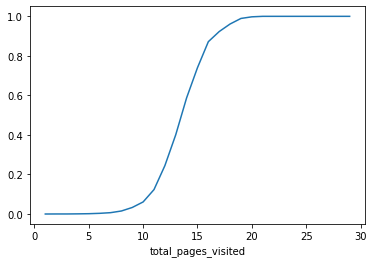

In [10]:
for col in df.columns:
    if col == 'converted':
        continue
    elif col == 'total_pages_visited':
        print(df.groupby([col])['converted'].mean())
        df.groupby([col])['converted'].mean().plot()
    else:
        print(df.groupby([col])['converted'].mean())
        df.groupby([col])['converted'].mean().plot.bar()
    plt.show()

# Modeling and Insights

Start by getting a baseline accuracy by looking at the majority classifier. If we simply guess the majority label (not converted) we score 96.8%. Ideally, any model we make should beat that.

In [11]:
baseline_accuracy = df['converted'].value_counts(normalize=True)[0]
print('Baseline Accuracy:', baseline_accuracy)

Baseline Accuracy: 0.9677480565974484


One Hot Encode all of the categorical variables

In [12]:
df_one_hot = pd.get_dummies(df, drop_first=False)

A Random Forest Classifier was chosen because of its quick training and prediction time, and it is moderately interpretable through the use of a single decision tree. Interpretability is key since we are making recommendations to other departments.

In [13]:
X, y = df_one_hot.drop('converted', axis='columns'), df_one_hot['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

rf_model = RandomForestClassifier(max_features=3, oob_score=True)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

OOB Accuracy is better than the baseline but nearly a third of conversions are False Negatives.

In [14]:
print('OOB accuracy:', rf_model.oob_score_)
print('\nConfusion Matrix')
print(pd.DataFrame(confusion_matrix(y_train, 
                   rf_model.oob_decision_function_[:,1].round(),
                   labels=[0, 1])))

OOB accuracy: 0.9842106753771501

Confusion Matrix
        0     1
0  203863  1155
1    2190  4644


Similar results against the test case. Between the OOB and Test Accuracy, we know we are probably not overfitting with our model. Ideally, once all stakeholders are comfortable with the model we would pull more recent data as a validation set and verify one last time that the model is working as expected.

In [15]:
print('Test accuracy:', rf_model.score(X_test, y_test))
print('\nConfusion Matrix')
print(pd.DataFrame(confusion_matrix(y_test, 
                   rf_model.predict(X_test),
                   labels=[0, 1])))

Test accuracy: 0.9843309757920764

Confusion Matrix
        0     1
0  100436   546
1    1089  2275


Our first goal was to predict conversion rate which we have accomplished with this model. We could tweak the threshold to minimize false positives or negatives but the real immediate value is in deriving actionable insights for the product and marketing teams. Below, in the recommendations, we will also discuss possible uses for predicting conversion rate in real time.

By a large margin, we see `total_pages_visited` is the most important variable. This makes sense because purchasing requires additional page views and people looking to buy are more likely to stick around/browse before checkout.

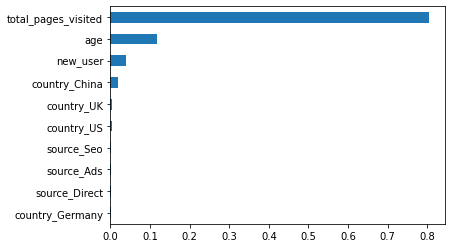

In [16]:
feature_importances = pd.Series(rf_model.feature_importances_, 
                                index=X_train.columns)
feature_importances.sort_values().plot(kind='barh')
plt.show()

Drop `total_pages_visited` to get better insights into the over variables and to prevent possible unintended data leakage. Viewing more pages including the checkout pages makes it easier for our model to predict conversion but we may want to know subtler cues to act on sooner. Without the `total_pages_visited` we need to adjust the weights so the model predicts some conversions.

In [17]:
rf_model_no_views = RandomForestClassifier(n_estimators=100, max_features=3, 
                                           oob_score=True, 
                                           class_weight={0:1, 1:10})
rf_model_no_views.fit(X_train.drop(['total_pages_visited'], axis='columns'), 
                      y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 10}, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [18]:
print('OOB accuracy:', rf_model_no_views.oob_score_)
print('\nConfusion Matrix')
print(pd.DataFrame(confusion_matrix(y_train, 
                   rf_model_no_views.oob_decision_function_[:,1].round(),
                   labels=[0, 1])))

OOB accuracy: 0.8829890678398127

Confusion Matrix
        0      1
0  183888  21130
1    3659   3175


We see about a 10% drop in accuracy by dropping the `total_pages_visited`. Understandable considering how dominate the feature was. We might be able to eek out another percentage point of accuracy with hyperparameter tuning but this also might be an opportunity for additional recommendations around collecting more data points per visitor.

In [19]:
print('Test accuracy:', rf_model_no_views.score(X_test.drop('total_pages_visited',
                                                   axis='columns'), y_test))
print('\nConfusion Matrix')
print(pd.DataFrame(confusion_matrix(y_test, 
                   rf_model_no_views.predict(X_test.drop('total_pages_visited',
                                                          axis='columns')),
                                             labels=[0, 1])))

Test accuracy: 0.8836467138174918

Confusion Matrix
       0      1
0  90590  10392
1   1749   1615


Without `total_pages_visited`, `new_user` is now the most important variable, followed by `age` and `country_China`. Quite a few actionable recommendations can come from this chart alone but we'll discuss those below. Interestingly, the source of the site visit doesn't seem to matter much at all.

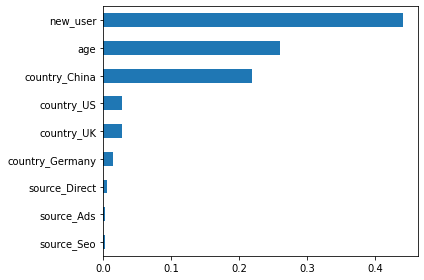

In [ ]:
feature_importances = pd.Series(rf_model_no_views.feature_importances_, 
                                index=X_train.drop('total_pages_visited', 
                                                   axis='columns').columns)
feature_importances.sort_values().plot(kind='barh')
plt.show()

PDP Takeaways
- Germany and UK have high value with the US right behind. China is nearly inconsequential and should be looked at further
- Age is a clear factor for conversion and drops off pretty fast. We can take a look at the decision tree to see what age cut off we should optimize the site for, likely between 25 and 30.
- Existing users are where a large chunk of the sales are at. This makes sense, if you are returning you are familiar with the product and found something compelling about the product or site.
- Source is about even between the three

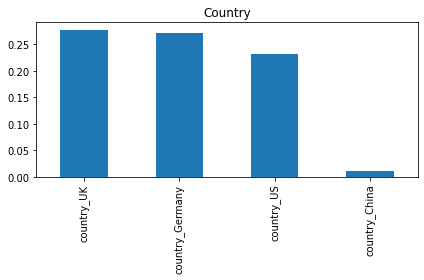

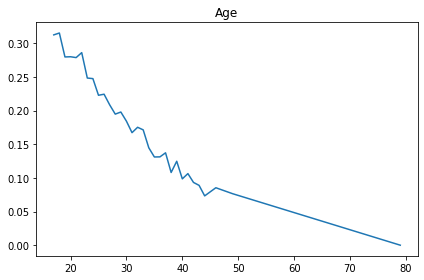

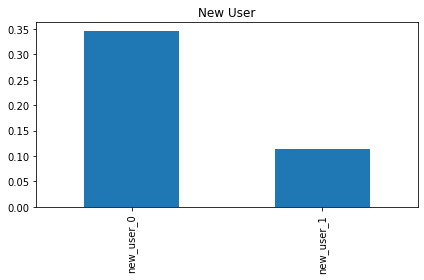

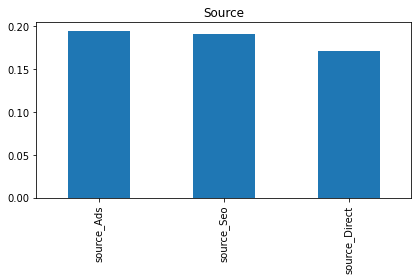

In [ ]:
pdp_dict = {'Country': ['country_China', 'country_Germany', 
                       'country_UK', 'country_US'],
            'Age': 'age',
            'New User': 'new_user',
            'Source': ['source_Direct', 'source_Seo', 'source_Ads']}

for key, value in pdp_dict.items():
    pdp_iso = pdp.pdp_isolate(
                model=rf_model_no_views, 
                dataset=X_train.drop('total_pages_visited', axis='columns'),      
                model_features=list(X_train.drop('total_pages_visited', 
                                                axis='columns')), 
                feature=pdp_dict[key], 
                num_grid_points=50)
    if key == 'Age':
        pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
        pdp_dataset.plot(title=key)
    else:
        pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
        pdp_dataset.sort_values(ascending=False).plot(kind='bar', title=key)
    plt.show()

Next we can build a decision tree to understand the most important segments of our data.

Tree Takeaways
- Looking at the tree splits confirms much of what we have already seen
- The age split is 30 for non-Chinese users, and 28 for Chinese users. Playing it safe, we can optimize the website for 30 and under

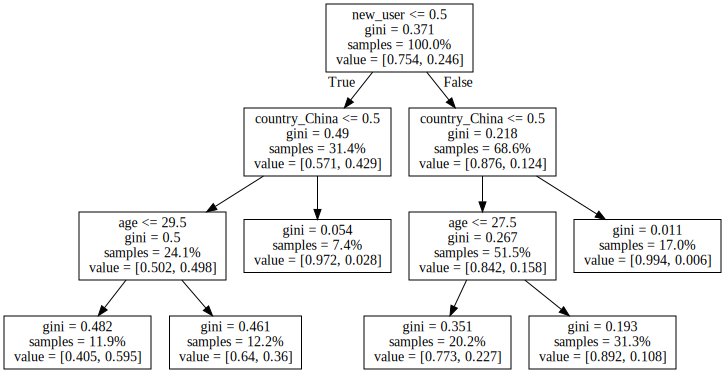

In [ ]:
# Train a Decision Tree
tree_model = DecisionTreeClassifier(max_depth=3,class_weight={0:1, 1:10},
                                    min_impurity_decrease = 0.001)
tree_model.fit(X_train.drop('total_pages_visited', axis='columns'), y_train)

# Visualize the Decision Tree
export_graphviz(tree_model, out_file="tree_model.dot", 
                feature_names=X_train.drop('total_pages_visited', 
                                           axis='columns').columns, 
                proportion=True, rotate=False)
with open("tree_model.dot") as file:
    dot_graph = file.read()
  
tree_source = Source.from_file("tree_model.dot")
tree_source

# Recommendations for Marketing and Product Teams

1. There is an issue with converting Chinese users. The product team should take a look at it and test possible issues like translation and localization, or payment problems. With such a large market and user base (24% of visitors), this should be a top priority.

2. The site performs very well for German users but the user base of Germans is small (4% of visitors). Localization and marketing for the German market should be worthwhile; the upside is large if the conversion rate (25%) holds for them.

3. The site is well optimized for young people, so outreach and advertising to target the 17-30 year old demographic would likely show a solid ROI with minimal effort.

4. Existing users are more likely to purchase. Email targeting existing users to return to the site would be a low budget idea to potentially drive further sales.

5. The site performs poorly for users over 30. Likely this is due to the product but it would be worthwhile to test methods of capturing such a large demographic as ages 30+.

6. A/B testing email collection for new users might be worthwhile so that they can be contacted and incentivized to return to the site. Ad tracking like Facebook Pixel might be another way to go about this if it is not already in place.

# Recommendations for the Data Team

1. Refining the model further and then using it on the website to attempt to increase conversion rate would be worthwhile. Ideally, the model would help find users that are on the verge of conversion and offer them some incentive to convert such as a 10% discount code. Finding the ideal tipping point and incentive would be done through A/B Testing

2. The model loses 10% accuracy once we drop `total_pages_visited`. While it could be included in our model, the feature is a bit of a lagging indicator. Having the data team collect additional features (time on site, gender, pages visited, etc.) will likely increase model accuracy without relying on `total_pages_visited`.

3. Setting up monitoring and a dashboard for site KPI's should be built so that all stakeholders can see site performance in near-real time and streamline the process stepped through above.